# Identifiability test
In this noted book we investogate a 'cutting corners calculation' of the main aim of the research. We will determine the the quantity: $$\Delta \chi^{2} \sim \left(C_{l}^{1} - C_{l}^{2}\right)^{T} Cov^{-1}\left[C_{l}^{1}\right]\left(C_{l}^{1} - C_{l}^{2}\right)$$

in which $C_{l}^{1}$ would be corresponding to a cosmology of massless neutrinos, $C_{l}^{2}$ corresponds to the hypothetical cosmology containing a number of massive neutrinos and $Cov^{-1}\left[C_{l}^{1}\right]$ is the inverse of the Gaussian covariance. We will build this up simple and possibly explore more complicated renditions later on.

The idea is to calculate this quantity for multiple cosmologies with different neutrino properties given by $C_{l}^{2}$, compared to the $\Lambda CDM$ cosmology, containing only massless neutrinos. More specifically, we will look at the sensitivity in the auto correlation and cross-correlations of the cCMB lensing tracer with the existing tracers used in the 6x2pt. analysis.
These added correlations/angular power spectra, will make up a total 10x2pt. analysis. The goal of this reearch is to develope a forecasting of this analysis.

$\Delta \chi^{2}$ will give us a measure of the sesitivity of the angular power spectra to the neutrino paramters. This in essence could function as a forecast on the neutrino parameter constraining power of the extended analysis. We can relate the value of $\Delta \chi^{2}$ in a cutting corners way to the p-value $\todo{find anything on this p-value}$ which can give us a measure of the sensitivity:

$$\Delta \chi^{2} \sim p \begin{cases}
\ll 1, & \text{(significant) sensitivity}.\\
\sim 1, & \text{if there is no sensitivity}
\end{cases}
$$

and will thus allow us to say something about the potential of the extension of the 6x2pt, analysis by inclusion of the angular power spectra of the CMB lensing tracer. 

Another goal of this is simply the exploration of these processes, to whitness what is going on behind the scenes of the bigger cosmological piplines like cosmoSIS and firecrown.

----

This calculation has a few important elements that we take under the loop one by one.
We will start with defining the cosmologies that we want to investigate. It is these cosmologies that the angular power spectra will be calculated from.
Since we are concerned with the CMB spectra, we must also be concerned with the binning of the redshift space in between current day and last scattering. The accuracy of the analysis also depends on the binning and the properties of the binning process which we will investigate aswell.

The next element is the Gaussian covariance. In the most general case, the Gaussian covariance is a matrix containing the (co)variance between all angular power spectra in (different) bins.
We will start off simple and define a Gaussian covariance for auto correlated bins, such that the Gaussian covariance is diagonal. Later on, we can explore the complexities of the Gaussian covariance and build up the general case.

With these elements in order, we can perform the simplest version of the identifiability test and get an idea of the bigger picture in a small reduces setting.


An important note to make is that this quantitative test is purely based on the singled-out-effect ogf the neutrino parameters on the angular power spectra. As we know, the effects of the cosmological parameters on the matter power spectrum and therefore the angular power spectra are not unique, as we have seen in the previous notebooks:
- [notebook #1](https://github.com/XanderHenrik/Masters-Project/blob/fadf527a729419f612ee98618f3fcc42747736e1/notebooks/varying_P_k.ipynb)
- [notebook #2](https://github.com/XanderHenrik/Masters-Project/blob/fadf527a729419f612ee98618f3fcc42747736e1/notebooks/varying_C_l.ipynb)

This brief analysis in which we cut corners, does not take one of the biggest motivations for this research into account: namely that the inclusion of the CMB lensing angular power spectra can break the degenereacies between these parameters, allowing for an increased constraint on certain parameters after the breaking of these degeneracies.

In [1]:
# The required imports:

import numpy as np
import pyccl as ccl
import pylab as plt
import math
import glass.observations
%matplotlib inline

## Cosmologies
First of all we define the different neutrino based cosmologies.

The neutrino parameters to which cosmology is sensitive, and theoretically/phenomenologically the CMB should be sensitive to are:
- The total sum of neutrino masses, $\sum_{i} m_{\nu, i}$
- The effective number of active neutrino species, $N_{eff}$. In different words, the number of massive/massless neutrinos.

The different cosmologies we define below will mainly be based on these paramters and relative variations on these.


In [18]:
# We define the cosmology:
lcdm_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044)

# Alternate neutrino cosmology:
neutrino_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044, m_nu=0.12, mass_split='normal')
zero_mm_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044, m_nu=[0, 0.06, 0.06])
single_nu_cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, Neff=3.044, m_nu=0.12, mass_split='single')

# The specifics of the angular power spectra:
l = np.linspace(2, 500, 50) # multipole moments
z = np.linspace(0., 3.0, 50) # redshifts
a = (1./(1+z))[::-1]

""" 
# Redshift distribution:
nz = np.exp(-((z-0.5)/0.05)**2/2)
"""
 
 # Biases:
bias = 0.95/ccl.growth_factor(lcdm_cosmo, a) # bias
bias_NH = 0.95/ccl.growth_factor(neutrino_cosmo, a)
bias_zero_mm = 0.95/ccl.growth_factor(zero_mm_cosmo, a)
bias_single_nu = 0.95/ccl.growth_factor(single_nu_cosmo, a)

m_bias = np.ones_like(z) # Magnification bias
i_a = -0.004 * np.ones_like(z) # Intrinsic alignment amplitude

# Binning:
Define the spectroscopic and photometric bins in which we will specify our angular power spectra.
There are some different practices of binning, try to uncover those. **[$\todo{source?}$]()**

### Sidequest:
Find out if [glass.observations](https://glass.readthedocs.io/v2023.6/reference/observations.html#rd48878c677a1-1) allows for logarithmic binning.


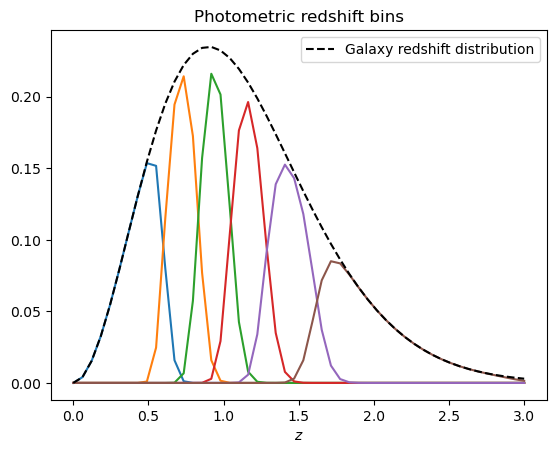

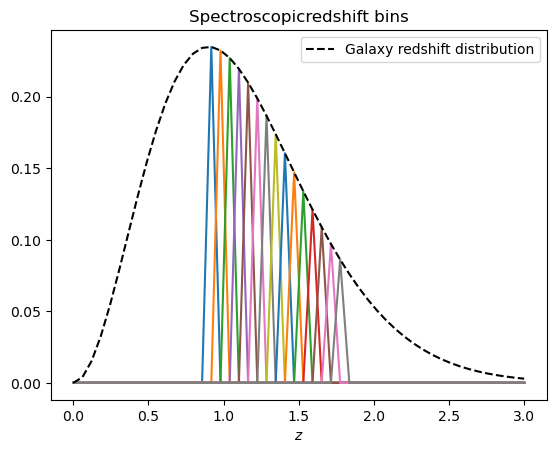

In [23]:
# We define the photometric and spectra through the following:

# Photometric:
n_bar = 0.3 # Assume a galaxy density and accompanying reshift distribution:
dndz = glass.observations.smail_nz(z, z_mode=0.9, alpha=2., beta=1.5)
dndz *= n_bar
zbins = glass.observations.equal_dens_zbins(z, dndz, nbins=6)
phot_tomo_bins = glass.observations.tomo_nz_gausserr(z, dndz, 0.03, zbins) # Where the bin error is 0.03

# Spectroscopic:
spec_z = (np.heaviside((z - 0.9), 1) - np.heaviside((z - 1.8), 1)) * dndz
spec_zbins = glass.observations.fixed_zbins(zmin=0.9, zmax=1.8, dz=0.05)
spec_tomo_bins = glass.observations.tomo_nz_gausserr(z, spec_z, 0.0003, spec_zbins)

# Show the photometric bins in a plot:
plt.figure()
plt.title("Photometric redshift bins")
for i in range(len(phot_tomo_bins)):
    plt.plot(z, phot_tomo_bins[i])
plt.plot(z, dndz, 'k--', label='Galaxy redshift distribution')
plt.legend()
plt.xlabel("$z$")
plt.show()

# Show the spectroscopic bins in a plot:
plt.figure()
plt.title("Spectroscopicredshift bins")
for i in range(len(spec_tomo_bins)):
    plt.plot(z, spec_tomo_bins[i])
plt.plot(z, dndz, 'k--', label='Galaxy redshift distribution')
plt.legend()
plt.xlabel("$z$")
plt.show()

### Defining the tracers:
Here we define the tracers we are interested in and which we want to use to define the 

In [69]:
# Define an empty dictionary for the tracers:
tracers = {}

# Define the tracers:
photo_clus = {i: ccl.NumberCountsTracer(lcdm_cosmo, dndz=(z, phot_tomo_bins[i]), bias=(z, bias), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(phot_tomo_bins))}
spec_clus = {i: ccl.NumberCountsTracer(lcdm_cosmo, dndz=(z, spec_tomo_bins[i]), bias=(z, bias), mag_bias=(z, m_bias), has_rsd=True) for i in range(len(spec_tomo_bins))}
wl = {i: ccl.WeakLensingTracer(lcdm_cosmo, dndz=(z, phot_tomo_bins[i]), has_shear=True) for i in range(len(phot_tomo_bins))}
cmb_l = ccl.CMBLensingTracer(lcdm_cosmo, z_source=1100., n_samples=5500)

print(wl[0])

<pyccl.tracers.NzTracer>
	num       kernel             transfer       prefac  bessel 
	 0  0xed24fb0e2b266780         None           2       -1   


### Angular power spectra of interest
With the tracers we defined above, we can nof set up the angular power spectra we are interested in. Look at the auto and cross corrlations of the CMB lensing tracer. These effectively are the correlations that extend the 6x2pt. analysis to the 10x2pt analysis:
- $\kappa$ x $\kappa $
- $\kappa$ x $\gamma^{\epsilon}$
- $\kappa$ x $\delta_{g}^{p}$
- $\kappa$ x $\delta_{g}^{s}$

In [70]:
# Define the auto and cross correlations of the CMB lensing tracer within the 6xapt framework:
auto_cmb = ccl.angular_cl(lcdm_cosmo, cmb_l, cmb_l, l, l_limber=1120)
cmb_wl = {i: ccl.angular_cl(lcdm_cosmo, cmb_l, wl[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
cmb_gc_ph = {i: ccl.angular_cl(lcdm_cosmo, cmb_l, photo_clus[i], l, l_limber=1120) for i in range(len(phot_tomo_bins))}
cmb_gc_sp = {i: ccl.angular_cl(lcdm_cosmo, spec_clus[i], cmb_l, l, l_limber=1120) for i in range(len(spec_tomo_bins))}

# For the gaussian covariance, we also need the auto-correlations of the tracers:
auto_gc_ph = {i: ccl.angular_cl(lcdm_cosmo, photo_clus[i], photo_clus[i], l) for i in range(len(phot_tomo_bins))}
auto_gc_sp = {i: ccl.angular_cl(lcdm_cosmo, spec_clus[i], spec_clus[i], l) for i in range(len(spec_tomo_bins))}
auto_wl = {i: ccl.angular_cl(lcdm_cosmo, wl[i], wl[i], l) for i in range(len(phot_tomo_bins))}

# The noise types accompanying the angular power spectra:
# Poisson error for galaxy clustering noise, point sources tracing homogeneous background field:
noise_gc = 1/n_bar * np.ones_like(auto_gc_ph[0])

# Combined Poisson and Gaussian error for the point source distributions and Gaussian shear of galaxy shapes:
sigma_e = 0.28 # sigma_e_squared
noise_wl = (sigma_e**2)/n_bar * np.ones_like(auto_wl[0])

# For the CMB lensing noise we reference the method of Planck, resulting in:
noise_cmb_l = np.loadtxt('/home/xander/Masters-Project/notebooks/cmb_noise_Planck.txt')[:, 1]

# Gaussian diagonal covariance

Here we figure out the Gaussian diagonal covariance and try to code this ourselves.
Look at
- Gaussian covariance for the $C_{l}$'s; (Dodelson, example 12.1; section 14.2)
- Different noise types
- Expressions for the different types of probes
- Wick's theorem

*Guess:*
1. Gaussian diagonal covariance describes an striclty auto-correlated parameter space. This is expressed in a diagonal covariance matrix, in which the variance in each parameter is Gaussian. The fact that the covariance matrix is diagonal means that any cross-correlations are disregarded. Thus, the parameters panning parameter space are *univariant* in auto-correlations and invariant in cross-correlations.

Look at sources:
- **[Section 2.5: Johnston, H., Chisari, N. E., Joudaki, S., Reischke, R., Stölzner, B., Loureiro, A., ... & Zhang, Y. H. (2024). 6x2pt: Forecasting gains from joint weak lensing and galaxy clustering analyses with spectroscopic-photometric galaxy cross-correlations. arXiv preprint arXiv:2409.17377](https://arxiv.org/abs/2409.17377)**
- **[Section 6: Rassat, A., Land, K., Lahav, O., & Abdalla, F. B. (2007). Monthly Notices of the Royal Astronomical Society, 377(3), 1085-1094.](https://watermark.silverchair.com/mnras0377-1085.pdf?token=AQECAHi208BE49Ooan9kkhW_Ercy7Dm3ZL_9Cf3qfKAc485ysgAAA5AwggOMBgkqhkiG9w0BBwagggN9MIIDeQIBADCCA3IGCSqGSIb3DQEHATAeBglghkgBZQMEAS4wEQQMwbi2HLzrf3VtF_tBAgEQgIIDQ3YCxz_hwaRlcPM68Treuqkhb3c9-phZGoaHN6CJwoaIHwKG6TezsoaF7pLIpdR4BGIahf0e0uZXQht7x2Vuzb0QYYSj5MJOXPUnFZgk9GUSFKgOT0AiFScn_OZh7rK1i2glwLmMc66YstXfNrAflmxlSYRGEuBfILbYEtxLmicUwPVrmyLi_fJv96QZerxcesviCtEKA3LrI-ZgYlUIHOCrpu88SffoshsenjHBzt9rmJPetf7PrwgMDhL0mEKizmsaILsZgx0j-MWL8rEY9oz3xSCrSzcK6wXVVUfiKz2hfZp9xZkJvpwWIWB5czexmFKiDRIsZ2p4ReT2KvED0kXbK5ocHDyITsVIglihk0inPBTzRJ9mN4jVaNMaMJ_muLbUcMmMCMezaKdTGxWdeMk51g-DmN-t7ts_U-eMg0a5XDenD0CG-FDB9iR4jHK8uRRjZCWeq7W47QodiVoLdPdGd6jI9Clcv3Zc4MvCFs9mJlkWt6Z9I11d0djzMbKrCZf8CgdCU3arMxurJDnomLzQdjWG5deFHJHikFR464Qm0mx7F9jLq_eIqkZtbzaNGlY8_0DdhZ2-eTOkw-Y9v8PlDcjGzjC1GOBKk8uFNpCBOczk2TlITNRftSTFjo3JgF3m-SOTJbiJXWxCsDUGvuwqskCTH01ZaL_MhNtiwE_Sa1wsx9dxx5p0rCQ-aC8xwOzj4XhBzYphkziK-aPEloKsgzrd2GYwDkzaw-aV6l0X_jLIQLzd-ljQVirjuBHGyM30lRXRzoYnTu6227D9VcpVFzw_m816w2rFqC2wl1SP3ySGvndoKzIb1PAzTzlBMTWdJtfvHcjU7E6fdGfFlu6AjjFHz8jki1KT5POLTr-iEqYIcIOjjcSelTPFEybb1tO3UrLpTGHLJNE_osglSDELa7CUvIkbeVLvnuMgHbStuO9vO87U3M61v9z05BwuLPT_pJCGZgPoztHzhsvmv7vsbmr8drrJPMIcPty6EXPhMQqp8CfRQ8dxoDYUwCTjJeKc1147AuT24yXQ7CZ1SAnjem1byWyK7UI2WWTRRQxOdPHWHlQ77kTDcmq7IKNlUiLmmwVUBVtrkIEnlJiRWO3DJMY)**
- **[Later chapters of: Modern Cosmology; S. Dodelson, F. Schmidt](https://books.google.se/books?hl=nl&lr=&id=TpUmEQAAQBAJ&oi=fnd&pg=PP1&dq=modern+cosmology+dodelson&ots=BBo0fsLhcW&sig=KC-2ksaqhpjJvRv05wjpd2nS8Lg&redir_esc=y#v=onepage&q=modern%20cosmology%20dodelson&f=false)**


## Analytical expression:
We can write down the analytical expression for the Gaussian covariance through:
$Z = Cov\left[\hat{C}^{ij}(\ell)\hat{C}^{mn}(\ell')\right]$, with:
$$Cov\left[\hat{C}^{ij}(\ell)\hat{C}^{mn}(\ell')\right] = \frac{\delta_{\ell\ell'}^{K}}{f_{sky} (2\ell + 1)}\left(\hat{C}^{im}(\ell)\hat{C}^{jn}(\ell') + \hat{C}^{in}(\ell)\hat{C}^{jm}(\ell')\right)$$

where $4\pi f_{sky} = A_{survey}$ the fraction of the sky considered in the survey, $\delta_{\ell\ell'}^{K}$ is the K-dimensional Dirac delta which ensures that the multipole moments ($\ell$) are independent. In this expression we must note that $\hat{C}^{ij}(\ell)$ is the observed angular power spectrum. This means that it contains both the signal $\left(S^{ij}(\ell)\right)$ and the noise $\left(N^{ij}\right)$:
$$\hat{C}^{ij}(\ell) = S^{ij}(\ell) + N^{ij}\delta_{ij} $$

More specifically,
$$
\hat{C}^{ij} (\ell) = \begin{cases}
S^{ij} (\ell) + N_{source}^{ij}\delta_{ij}, & \text{if $i \wedge j \in$ source}.\\
S^{ij} (\ell) + N_{lens}^{ij}\delta_{ij}, & \text{if $i \wedge j \in$ lens}.\\
S^{ij} (\ell), & \text{else}
\end{cases}
$$

Where the noise differs for the case of galaxy clustering, weak lensing or CMB lensing. Note also that the noise only occurs for the auto-correlations (e.g. the diagonal of the covariance). 

Note: For CMB lensing, we make use of the noise as defined by Planck, stowed away in the file 'cmb_noise_Planck.txt' which we read in and use when needed.

A (7, 7) matrix, which contains the following:
 [[39.68253968 32.53968254 22.22222222 42.46031746 35.31746032 28.57142857
  38.49206349]
 [ 8.1027668   6.64426877  4.53754941  8.66996047  7.21146245  5.83399209
   7.85968379]
 [ 3.16027088  2.59142212  1.76975169  3.38148984  2.81264108  2.27539503
   3.06546275]
 [ 4.22590837  3.46524487  2.36650869  4.52172196  3.76105845  3.04265403
   4.09913112]
 [ 2.70352369  2.21688943  1.51397327  2.89277035  2.40613609  1.94653706
   2.62241798]
 [ 1.7769003   1.45705824  0.99506417  1.90128332  1.58144126  1.27936821
   1.72359329]
 [ 2.01579385  1.65295096  1.12884456  2.15689942  1.79405653  1.45137157
   1.95532003]]


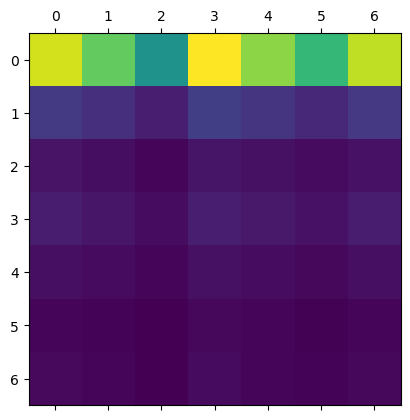

In [71]:
# Now we define a function that gives us the Gaussian coavariance based on the probe, the corresponding noise and surveysurface on the observed sky,
# a redshift distribution, bins and their binwidth.

def Gauss_cov(l, ang_power_spectrum, noise, f_sky, redshift_dist=None, bins=None, cross=False):
    # We calculate the Gaussia covariance based on the true-model tracer. The angular power spectrum that represents LCDM
    cov = np.zeros(shape=(len(ang_power_spectrum), len(ang_power_spectrum)))
    
    # We separate the cases of auto and cross-correlations:
    if cross == False:
        
        # Now we need to take into account the noise acompanying the angular power spectrum
        for i in range(len(l)):
            for j in range(len(l)):

                # For the diagonal elements, we compute auto correlations of the same probes, thus we includer the noise terms. Assume
                if i == j:
                    cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spectrum[i] * ang_power_spectrum[j] + ang_power_spectrum[i] * ang_power_spectrum[j] + noise[i] * ang_power_spectrum[j] + ang_power_spectrum[i] * noise[j] + noise[i] * noise[j])
                
                # For the non-diagonal elements:
                else:
                    cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spectrum[i] * ang_power_spectrum[j] + ang_power_spectrum[i] * ang_power_spectrum[j])
    
    # Now for the cross-correlations:
    else:
        for i in range(len(l)):
            for j in range(len(l)):
                cov[i, j] = 1/(f_sky * (2 * l[i] + 1)) * (ang_power_spectrum[i] * ang_power_spectrum[j])
    
    return cov

tracer = np.array([100, 82, 56, 107, 89, 72, 97])
noise = np.ones_like(tracer)
l = np.linspace(10, 200, len(tracer))

print("A", Gauss_cov(l, tracer, noise, 12, cross=True).shape, "matrix, which contains the following:\n", Gauss_cov(l, tracer, noise, 12, cross=True))

plt.matshow(Gauss_cov(l, tracer, noise, 2, cross=True), None)
plt.show()

In [72]:
# Start with a simplest case of the diagonal Gaussian covariance:

# The very implest case returns a vector that represents the daigonal of the Gaussian covariance, only consisting of auto-correlated bins
def diag_Gaussian_cov(l, IM, JN, IN, JM, f_sky, noise_a, noise_b):

    # Expect the entries IN & JM to include the noise: so they should be IN = Signal + Noise
    ez_diag_cov = {}
    pref = 1 / (f_sky * (2 * l + 1))
    for key in IM.keys():
        for el in JN.keys():
            if key == el:
                ez_diag_cov[key] = pref * ((IM[key] * JN[el]) + ((IN[key] + noise_a) * (JM[el] + noise_b)))
                
    return ez_diag_cov


# We look at the auto correlation of a single variation of the angularpower spectrum
def simple_Gaussian_cov(l, IM, JN, IN, JM, f_sky, noise=None):
    
    # Set the noise to 0 if there is no noise specified:
    if noise is None:
        noise = np.zeros_like(l)
    
    # Initiate the covariance matrix:
    simple_cov = np.zeros(shape=(len(l), len(l)))
    
    # Now we calculate the covariance of the elements:
    for i in range(len(l)): # NOTE: Should the range not be over the bins?
        pref = 1/(f_sky * (2*l[i] + 1))
        for j in range(len(l)):
            if i == j:
                simple_cov[i, j] = pref * ((IM[i] * JN[j]) + (IN[i] * JM[j]) + (noise[i] * noise[j]) + ((IM[i] + IN[i]) * noise[j]) + ((JN[j] + JM[j]) * noise[i]))
            else:
                simple_cov[i, j] = pref * ((IM[i] * JN[j]) + (IN[i] * JM[j]))

    return simple_cov

In [73]:
# Now we want to determine the Gaussian covariance:
cov_cmbl_wl = simple_Gaussian_cov(l, cmb_wl[0], cmb_wl[0], auto_cmb, auto_wl[0], 0.00012, noise=noise_wl)
cov_cmbl_wl_next = simple_Gaussian_cov(l, cmb_wl[5], cmb_wl[5], auto_cmb, auto_wl[5], 0.00012, noise=noise_wl)

ez_Gauss = diag_Gaussian_cov(l, cmb_wl, cmb_wl, auto_cmb, auto_wl, 0.0012, noise_cmb_l[0:len(l)], noise_wl)
mat_ez_Gauss = np.zeros_like(cov_cmbl_wl)
for i in range(len(l)):
    for j in range(len(l)):
        if i == j:
            mat_ez_Gauss[i, j] = ez_Gauss[0][i]

# plt.matshow(cov_cmbl_wl)
# plt.matshow(cov_cmbl_wl_next)
plt.matshow(mat_ez_Gauss)
plt.show()

ValueError: operands could not be broadcast together with shapes (7,) (50,) 

# $\Delta \chi ^{2}$
Now we can determine the value of $\Delta \chi ^{2}$ in each bin; to do so we calculate the following:$$\Delta \chi ^{2} \sim \left(C_{l}^{1} - C_{l}^{2}\right)^{T} Cov^{-1}\left[C_{l}^{1}\right]\left(C_{l}^{1} - C_{l}^{2}\right)$$

in which $C_{l}^{1}$ would be corresponding to a cosmology of massless neutrinos and $C_{l}^{2}$ corresponds to the hypothetical cosmology containing a number of massive neutrinos


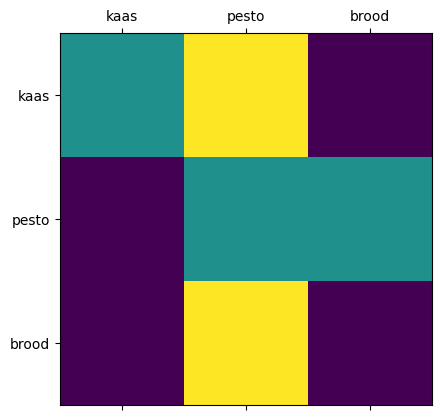

In [17]:
# For each bin we obtain a value for the Delta chi-squared:
test_chi = np.array([[1, 2, 0], [0, 1, 1], [0, 2, 0]])

plt.matshow(test_chi)
plt.xticks([0, 1, 2], ["kaas", "pesto", "brood"])
plt.yticks([0, 1, 2], ["kaas", "pesto", "brood"])
plt.show()